# Install Libraries

In [ ]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
'''
If import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.
'''
!pip uninstall -y numpy
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.11.0 requires scipy>=1.6.0, which is not installed.
statsmodels 0.14.4 requires scipy!=1.9.2,>=1.8, which is not installed.
lightgbm 4.5.0 requires scipy, which is not installed.
sklearn-pandas 2.2.0 requires scipy>=1.5.1, which is not installed.
arviz 0.21.0 requires scipy>=1.9.0, which is not installed.
cvxpy 1.6.5 requires scipy>=1.11.0, which is not installed.
scikit-learn 1.6.1 requires scipy>=1.6.0, which is not installed.
pymc 5.21.2 requires scipy>=1.4.1, which is not installed.
plotnine 0.14.

In [ ]:
!pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
  Using cached deeprobust-0

In [ ]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("PyTorch Version:", torch.__version__)
print("PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sparse

PyTorch Version: 2.0.0+cu117
PyG Installed: 2.6.1
Numpy Installed: 1.23.5


In [ ]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
from torch_geometric.data import Data
from torch_sparse import from_scipy

from deeprobust.graph.global_attack import Metattack
print("Metattack Imported Successfully")

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
# Flickr: Flickr
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
from ogb.nodeproppred import PygNodePropPredDataset

Metattack Imported Successfully


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [ ]:
'''
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import os

def subset_graph(data, num_nodes_subset, save_path):
  #Make a subset of a graph if it is too big
  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]
  perm = perm.sort()[0]

  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)

  x = data.x[perm] if data.x is not None else None
  y = data.y[perm] if data.y is not None else None

  new_data = Data(x=x, edge_index=edge_index, y=y)
  torch.save(new_data, save_path)
  print(f"Saved subset graph to {save_path}")
  return new_data
'''

'\nfrom torch_geometric.utils import subgraph\nfrom torch_geometric.data import Data\nimport os \n\ndef subset_graph(data, num_nodes_subset, save_path):\n  #Make a subset of a graph if it is too big\n  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]\n  perm = perm.sort()[0]\n\n  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)\n\n  x = data.x[perm] if data.x is not None else None\n  y = data.y[perm] if data.y is not None else None\n\n  new_data = Data(x=x, edge_index=edge_index, y=y)\n  torch.save(new_data, save_path)\n  print(f"Saved subset graph to {save_path}")\n  return new_data\n'

In [ ]:
# Still failing because using all RAM
'''
import random

def subsample(data, num_nodes):
  node_indices = torch.randperm(data.num_nodes)[:num_nodes]
  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)
  data.x = data.x[node_indices]
  data.y = data.y[node_indices]

  # (Re)define masks
  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.train_mask[:int(0.6 * num_nodes)] = True

  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True

  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask[int(0.8 * num_nodes):] = True

  data.edge_index = edge_index
  return data
'''

'\nimport random\n\ndef subsample(data, num_nodes):\n  node_indices = torch.randperm(data.num_nodes)[:num_nodes]\n  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)\n  data.x = data.x[node_indices]\n  data.y = data.y[node_indices]\n  \n  # (Re)define masks\n  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.train_mask[:int(0.6 * num_nodes)] = True\n\n  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n\n  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.test_mask[int(0.8 * num_nodes):] = True\n\n  data.edge_index = edge_index\n  return data\n'

In [ ]:
# Still failing because uses all RAM

'''
def subsample_ogbn_proteins(dataset, num_nodes=7000):
  full_data = dataset[0]
  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]

  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)
  edge_attr = full_data.edge_attr[edge_mask]

  # Simulate node features if missing
  x = torch.zeros((num_nodes, 1))

  # Subsample y
  y = full_data.y[sampled_nodes]

  # Generate new train/val/test masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  train_mask[:int(0.6 * num_nodes)] = True
  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True
  test_mask[int(0.8 * num_nodes):] = True

  return Data(
      x=x,
      edge_index=edge_index,
      edge_attr=edge_attr,
      y=y,
      train_mask=train_mask,
      val_mask=val_mask,
      test_mask=test_mask,
  )
'''

'\ndef subsample_ogbn_proteins(dataset, num_nodes=7000):\n  full_data = dataset[0]\n  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]\n\n  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)\n  edge_attr = full_data.edge_attr[edge_mask]\n\n  # Simulate node features if missing\n  x = torch.zeros((num_nodes, 1))\n\n  # Subsample y\n  y = full_data.y[sampled_nodes]\n\n  # Generate new train/val/test masks\n  train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n\n  train_mask[:int(0.6 * num_nodes)] = True\n  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n  test_mask[int(0.8 * num_nodes):] = True\n\n  return Data(\n      x=x,\n      edge_index=edge_index,\n      edge_attr=edge_attr,\n      y=y,\n      train_mask=train_mask,\n      val_mask=val_mask,\n      test_mask=test_mask,\n  )\n'

In [ ]:

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    return Planetoid(root=f"./data/{name}", name=name)[0]
  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
    return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    return PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")[0]
  elif name == "Flickr":
    return Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}

# Load datasets for all datasets when using ogbn-proteins, flickr, and pubmed
'''
def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]

    if name == "PubMed":
      data = subsample(data, 5000)
    return data

  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
   return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")
    return subsample_ogbn_proteins(dataset, num_nodes=7000)

  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
    return subsample(data, 5000)
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}
'''

Processing...
Done!
Processing...
Done!
Processing...
Done!
Extracting tmp/polblogs/raw/polblogs.tar.gz
Processing...
Done!
Processing...
Done!


Downloaded 0.21 GB: 100%|██████████| 216/216 [00:19<00:00, 11.29it/s]


Extracting ./data/ogb/proteins.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 747.65it/s]


Saving...


Done!
Processing...
Done!


'\ndef load_dataset(name):\n  if name in ["Cora", "Citeseer", "PubMed"]:\n    data = Planetoid(root=f"./data/{name}", name=name)[0]\n\n    if name == "PubMed":\n      data = subsample(data, 5000)\n    return data\n\n  elif name == "Texas":\n    return WebKB(root=f"./data/{name}", name=name)[0]\n  elif name == "PolBlogs":\n   return PolBlogs(root=f"./tmp/polblogs")[0]\n  elif name == "ogbn-proteins":\n    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")\n    return subsample_ogbn_proteins(dataset, num_nodes=7000)\n\n  elif name == "Flickr":\n    data = Flickr(root=f"./data/Flickr")[0]\n    return subsample(data, 5000)\n  else:\n    raise ValueError("Dataset not found")\n\ndatasets = {\n    "Cora": load_dataset("Cora"),\n    "Citeseer": load_dataset("Citeseer"),\n    "PubMed": load_dataset("PubMed"),\n    "PolBlogs": load_dataset("PolBlogs"),\n    "Texas": load_dataset("Texas"),\n    "ogbn-proteins": load_dataset("ogbn-proteins"),\n    "Flickr": load_dataset("Fli

# Define GCN Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [ ]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [ ]:
def apply_metattack(model, data, num_perturbations):
  # Convert adjacency matrix and features to sparse format
  adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.numpy())
  labels = data.y.numpy()

  # Get train and unlabeled indices
  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  # Initialize Metattack
  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  # Perform attack
  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  # Ensure `modified_adj` and `modified_features` exist and return them
  modified_adj = attacker.modified_adj
  modified_features = attacker.modified_features

  # If Metattack doesn't return features, use the original
  if modified_features is None:
      modified_features = data.x

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [ ]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  print(f"perturbed_adj type: {type(perturbed_adj)}")

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices()

  # Use original features if perturbed ones are not returned
  if perturbed_features is None:
        perturbed_x = data.x
  else:
      if hasattr(perturbed_features, "toarray"):
          perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float)
      else:
          perturbed_x = perturbed_features

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  # Ensure test_mask is correctly sized and boolean
  if data.test_mask.shape[0] != data.num_nodes:
    print(f"Adjusting test_mask size for {data.dataset_name}...")
    # Truncate or adjust the size
    data.test_mask = data.test_mask[:data.num_nodes]

  # Flatten test_mask if it's not 1D
  if len(data.test_mask.shape) > 1:
      data.test_mask = data.test_mask.flatten()

  # Ensure data.test_mask has the correct size and is boolean
  data.test_mask = data.test_mask[:data.num_nodes].to(torch.bool)

  #if len(data.test_mask.shape) == 1:
    # Ensure it is boolean
    #data.test_mask = data.test_mask.to(torch.bool)

  # Check the shapes of predictions and ground truth labels
  print(f"Prediction shape: {out.shape}")
  print(f"test_mask shape: {data.test_mask.shape}")
  print(f"Ground truth labels shape: {data.y.shape}")

  # Ensure data.y has the same size as test_mask
  assert data.y.shape[0] == data.num_nodes, "data.y shape mismatch with num_nodes"

  # Get predicted class labels
  pred = out.argmax(dim=1)
  # Compare predictions to ground truth
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
  # Calculate accuracy
  acc = correct / data.test_mask.sum().item()

  return acc

# Visualization

In [ ]:
def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Create Masks

In [ ]:
def split_masks(data, train_ratio=0.6, val_ratio=0.2):
  num_nodes = data.num_nodes
  indices = torch.randperm(num_nodes)

  train_size = int(train_ratio * num_nodes)
  val_size = int(val_ratio * num_nodes)

  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  data.train_mask[indices[:train_size]] = True
  data.val_mask[indices[train_size:train_size + val_size]] = True
  data.test_mask[indices[train_size + val_size:]] = True

  return data

# Run Experiments

In [ ]:
# TODO: make num_perturbations 0.2 * number of edges (once initial experiments run)

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # Already a Data object
    data = dataset
  else:
    # Dataset is a list-like object (like Planetoid)
    data = dataset[0]

  if data.x is None:
    # Patching missing features (for PolBlogs, speficially)
    # All zero-features carry no useful info -> poor performance,
    # so each node has a unique identifier (one-hot encoding). GNN can differentiate them based on graph structure + node identity
    print(f"{dataset_name} patching missing features...")
    data.x = torch.eye(data.num_nodes)

  # Check the shape of the masks and labels BEFORE: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  if not hasattr(data, 'train_mask') or data.train_mask.shape[0] != data.num_nodes:
    # dataset that doesnt come with masks ie. built-in train/test/val splits
    print(f"{dataset_name} making masks...")
    data = split_masks(data)
  else:
    if len(data.train_mask.shape) > 1:
      # If the train_mask exists but is not 1D, fix it to be
      print(f"Fixing train_mask_shape for {dataset_name}...")
      data.train_mask = data.train_mask.view(-1)

  # check train_mask is correct (Texas)
  if data.train_mask.shape[0] != data.num_nodes:
    print(f"Adjusting train_masks size for {dataset_name}...")
    # Truncate or adjust the size
    data.train_mask = data.train_mask[:data.num_nodes]
  if len(data.train_mask.shape) == 1:
    # Ensure it is boolean
    data.train_mask = data.train_mask.to(torch.bool)

  # Check the shape of the masks and labels AFTER: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  num_classes = len(torch.unique(data.y))

  print("=" * 100)
  print(f"Dataset: {dataset_name}\n")
  print(f"Number of nodes: {data.num_nodes}")
  print(f"Number of features: {data.num_features}")
  print(f"Number of classes: {num_classes}\n")

  model = GCN(data.num_features, 16, num_classes)
  model = train_model(model, data)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")

  num_perturbations = int(data.edge_index.size(1) * 0.01)
  print(f"Running on {num_perturbations} perturbations")
  # TODO: make num_perturbations 0.2 * number of edges once initial experiments run
  perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=num_perturbations)
  edge_index_perturbed = perturbed_adj.nonzero().t()

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

  acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
  print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")


# Execution

Dataset: Cora

Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch 0, Loss: 1.9524
Epoch 10, Loss: 0.8456
Epoch 20, Loss: 0.2643
Epoch 30, Loss: 0.1047
Epoch 40, Loss: 0.0679
Epoch 50, Loss: 0.0617
Epoch 60, Loss: 0.0441
Epoch 70, Loss: 0.0378
Epoch 80, Loss: 0.0411
Epoch 90, Loss: 0.0440
----------------------------------------------------------------------------------------------------
Original Graph


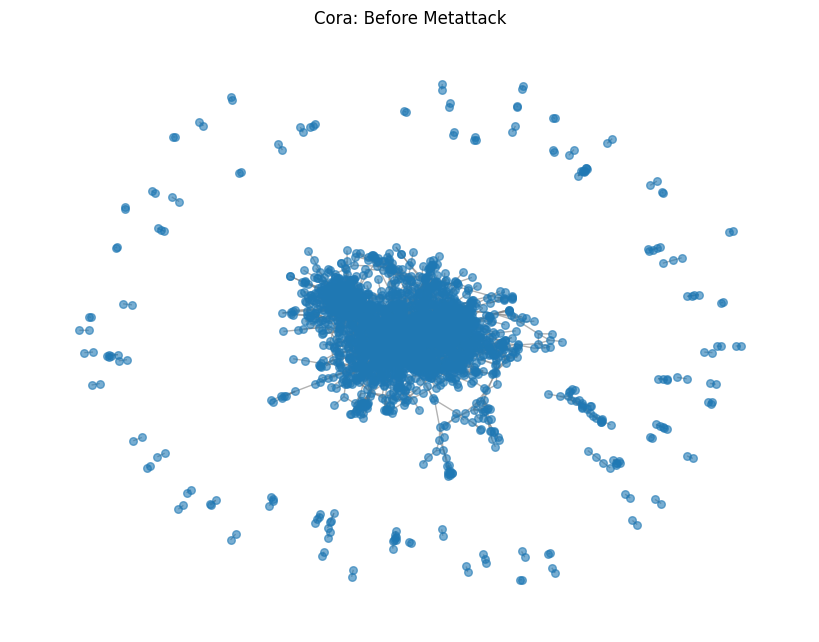

Running on 211 perturbations


Perturbing graph:   0%|          | 0/211 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.6492728590965271
GCN acc on unlabled data: 0.7885514018691588
attack loss: 0.346646249294281


Perturbing graph:   0%|          | 1/211 [00:17<1:02:41, 17.91s/it]

GCN loss on unlabled data: 0.6852059960365295
GCN acc on unlabled data: 0.7916666666666666
attack loss: 0.34359827637672424


Perturbing graph:   1%|          | 2/211 [00:39<1:09:42, 20.01s/it]

GCN loss on unlabled data: 0.7039938569068909
GCN acc on unlabled data: 0.7737538940809969
attack loss: 0.3528505861759186


Perturbing graph:   1%|▏         | 3/211 [01:00<1:11:05, 20.51s/it]

GCN loss on unlabled data: 0.7393073439598083
GCN acc on unlabled data: 0.7725856697819314
attack loss: 0.34826427698135376


Perturbing graph:   2%|▏         | 4/211 [01:17<1:06:21, 19.24s/it]

GCN loss on unlabled data: 0.7238513231277466
GCN acc on unlabled data: 0.7651869158878505
attack loss: 0.37508925795555115


Perturbing graph:   2%|▏         | 5/211 [01:35<1:03:34, 18.51s/it]

GCN loss on unlabled data: 0.707150936126709
GCN acc on unlabled data: 0.7827102803738317
attack loss: 0.3621445596218109


Perturbing graph:   3%|▎         | 6/211 [01:53<1:03:24, 18.56s/it]

GCN loss on unlabled data: 0.769719123840332
GCN acc on unlabled data: 0.7729750778816199
attack loss: 0.37421396374702454


Perturbing graph:   3%|▎         | 7/211 [02:10<1:01:43, 18.15s/it]

GCN loss on unlabled data: 0.7151152491569519
GCN acc on unlabled data: 0.7819314641744548
attack loss: 0.37095561623573303


Perturbing graph:   4%|▍         | 8/211 [02:28<1:00:34, 17.90s/it]

GCN loss on unlabled data: 0.7479382753372192
GCN acc on unlabled data: 0.7718068535825545
attack loss: 0.39795857667922974


Perturbing graph:   4%|▍         | 9/211 [02:46<1:00:27, 17.96s/it]

GCN loss on unlabled data: 0.7218083143234253
GCN acc on unlabled data: 0.7718068535825545
attack loss: 0.39386484026908875


Perturbing graph:   5%|▍         | 10/211 [03:03<59:10, 17.66s/it] 

GCN loss on unlabled data: 0.7774046659469604
GCN acc on unlabled data: 0.7663551401869159
attack loss: 0.3768822252750397


Perturbing graph:   5%|▌         | 11/211 [03:20<58:23, 17.52s/it]

GCN loss on unlabled data: 0.768456220626831
GCN acc on unlabled data: 0.7760903426791277
attack loss: 0.3795550763607025


Perturbing graph:   6%|▌         | 12/211 [03:39<59:04, 17.81s/it]

GCN loss on unlabled data: 0.7568419575691223
GCN acc on unlabled data: 0.7749221183800623
attack loss: 0.37495091557502747


Perturbing graph:   6%|▌         | 13/211 [03:56<58:17, 17.67s/it]

GCN loss on unlabled data: 0.8001287579536438
GCN acc on unlabled data: 0.758177570093458
attack loss: 0.4123607575893402


Perturbing graph:   7%|▋         | 14/211 [04:14<58:38, 17.86s/it]

GCN loss on unlabled data: 0.773961067199707
GCN acc on unlabled data: 0.7644080996884736
attack loss: 0.38674110174179077


Perturbing graph:   7%|▋         | 15/211 [04:32<57:54, 17.73s/it]

GCN loss on unlabled data: 0.8066549897193909
GCN acc on unlabled data: 0.7605140186915887
attack loss: 0.4019908010959625


Perturbing graph:   8%|▊         | 16/211 [04:49<57:21, 17.65s/it]

GCN loss on unlabled data: 0.8201873898506165
GCN acc on unlabled data: 0.7718068535825545
attack loss: 0.38591793179512024


Perturbing graph:   8%|▊         | 17/211 [05:08<58:34, 18.12s/it]

GCN loss on unlabled data: 0.8273792862892151
GCN acc on unlabled data: 0.7519470404984424
attack loss: 0.4052002727985382


Perturbing graph:   9%|▊         | 18/211 [05:33<1:04:50, 20.16s/it]

GCN loss on unlabled data: 0.8219765424728394
GCN acc on unlabled data: 0.7612928348909658
attack loss: 0.3922201097011566


Perturbing graph:   9%|▉         | 19/211 [05:51<1:02:40, 19.58s/it]

GCN loss on unlabled data: 0.7812843322753906
GCN acc on unlabled data: 0.7659657320872274
attack loss: 0.38327276706695557


Perturbing graph:   9%|▉         | 20/211 [06:09<1:00:08, 18.89s/it]

GCN loss on unlabled data: 0.8804286122322083
GCN acc on unlabled data: 0.7492211838006231
attack loss: 0.4169396460056305


Perturbing graph:  10%|▉         | 21/211 [06:27<59:27, 18.78s/it]  

GCN loss on unlabled data: 0.7694770097732544
GCN acc on unlabled data: 0.7694704049844237
attack loss: 0.38514548540115356


Perturbing graph:  10%|█         | 22/211 [06:45<57:48, 18.35s/it]

GCN loss on unlabled data: 0.825432538986206
GCN acc on unlabled data: 0.7496105919003115
attack loss: 0.41913285851478577


Perturbing graph:  11%|█         | 23/211 [07:02<56:41, 18.09s/it]

GCN loss on unlabled data: 0.8155741691589355
GCN acc on unlabled data: 0.7612928348909658
attack loss: 0.39586880803108215


Perturbing graph:  11%|█▏        | 24/211 [07:21<56:57, 18.27s/it]

GCN loss on unlabled data: 0.8394193649291992
GCN acc on unlabled data: 0.7449376947040498
attack loss: 0.42400887608528137


Perturbing graph:  12%|█▏        | 25/211 [07:38<55:43, 17.98s/it]

GCN loss on unlabled data: 0.9179348349571228
GCN acc on unlabled data: 0.7414330218068536
attack loss: 0.44202396273612976


Perturbing graph:  12%|█▏        | 26/211 [07:56<55:09, 17.89s/it]

GCN loss on unlabled data: 0.8138354420661926
GCN acc on unlabled data: 0.7562305295950156
attack loss: 0.43082401156425476


Perturbing graph:  13%|█▎        | 27/211 [08:13<54:36, 17.81s/it]

GCN loss on unlabled data: 0.8577834367752075
GCN acc on unlabled data: 0.7468847352024922
attack loss: 0.4255664348602295


Perturbing graph:  13%|█▎        | 28/211 [08:30<53:31, 17.55s/it]

GCN loss on unlabled data: 0.8518435955047607
GCN acc on unlabled data: 0.7531152647975078
attack loss: 0.43169644474983215


Perturbing graph:  14%|█▎        | 29/211 [08:49<54:06, 17.84s/it]

GCN loss on unlabled data: 0.8949637413024902
GCN acc on unlabled data: 0.7449376947040498
attack loss: 0.4493876099586487


Perturbing graph:  14%|█▍        | 30/211 [09:06<53:19, 17.68s/it]

GCN loss on unlabled data: 0.8802870512008667
GCN acc on unlabled data: 0.7328660436137072
attack loss: 0.44815462827682495


Perturbing graph:  15%|█▍        | 31/211 [09:24<53:07, 17.71s/it]

GCN loss on unlabled data: 0.8581833839416504
GCN acc on unlabled data: 0.7410436137071651
attack loss: 0.440507173538208


Perturbing graph:  15%|█▌        | 32/211 [09:42<53:19, 17.87s/it]

GCN loss on unlabled data: 0.7966634035110474
GCN acc on unlabled data: 0.7523364485981309
attack loss: 0.40121328830718994


Perturbing graph:  16%|█▌        | 33/211 [10:00<52:30, 17.70s/it]

GCN loss on unlabled data: 0.9684126973152161
GCN acc on unlabled data: 0.7332554517133957
attack loss: 0.4798692762851715


Perturbing graph:  16%|█▌        | 34/211 [10:17<51:46, 17.55s/it]

GCN loss on unlabled data: 0.9560434818267822
GCN acc on unlabled data: 0.743380062305296
attack loss: 0.4836779236793518


Perturbing graph:  17%|█▋        | 35/211 [10:35<52:14, 17.81s/it]

GCN loss on unlabled data: 0.8161777853965759
GCN acc on unlabled data: 0.7464953271028038
attack loss: 0.4260774254798889


Perturbing graph:  17%|█▋        | 36/211 [10:52<51:28, 17.65s/it]

GCN loss on unlabled data: 0.9935900568962097
GCN acc on unlabled data: 0.7266355140186916
attack loss: 0.4796423316001892


Perturbing graph:  18%|█▊        | 37/211 [11:11<51:35, 17.79s/it]

GCN loss on unlabled data: 0.883262574672699
GCN acc on unlabled data: 0.7410436137071651
attack loss: 0.4433485269546509


Perturbing graph:  18%|█▊        | 38/211 [11:28<50:48, 17.62s/it]

GCN loss on unlabled data: 0.9239997267723083
GCN acc on unlabled data: 0.7387071651090342
attack loss: 0.4662564694881439


Perturbing graph:  18%|█▊        | 39/211 [11:45<50:19, 17.56s/it]

GCN loss on unlabled data: 0.9518116116523743
GCN acc on unlabled data: 0.7445482866043613
attack loss: 0.49022239446640015


Perturbing graph:  19%|█▉        | 40/211 [12:03<50:38, 17.77s/it]

GCN loss on unlabled data: 0.8775395154953003
GCN acc on unlabled data: 0.7367601246105919
attack loss: 0.44931095838546753


Perturbing graph:  19%|█▉        | 41/211 [12:20<49:31, 17.48s/it]

GCN loss on unlabled data: 0.9192476272583008
GCN acc on unlabled data: 0.7394859813084113
attack loss: 0.47124183177948


Perturbing graph:  20%|█▉        | 42/211 [12:37<49:00, 17.40s/it]

GCN loss on unlabled data: 0.9269368052482605
GCN acc on unlabled data: 0.7461059190031153
attack loss: 0.4517858028411865


Perturbing graph:  20%|██        | 43/211 [12:56<49:49, 17.79s/it]

GCN loss on unlabled data: 0.9360343217849731
GCN acc on unlabled data: 0.7313084112149533
attack loss: 0.4798803925514221


Perturbing graph:  21%|██        | 44/211 [13:13<49:08, 17.65s/it]

GCN loss on unlabled data: 0.9678789377212524
GCN acc on unlabled data: 0.7207943925233645
attack loss: 0.5067329406738281


Perturbing graph:  21%|██▏       | 45/211 [13:31<48:40, 17.59s/it]

GCN loss on unlabled data: 0.9062672853469849
GCN acc on unlabled data: 0.7383177570093458
attack loss: 0.45820626616477966


Perturbing graph:  22%|██▏       | 46/211 [13:51<50:15, 18.27s/it]

GCN loss on unlabled data: 0.9616945385932922
GCN acc on unlabled data: 0.7239096573208723
attack loss: 0.4904002845287323


Perturbing graph:  22%|██▏       | 47/211 [14:12<52:29, 19.21s/it]

GCN loss on unlabled data: 0.9447797536849976
GCN acc on unlabled data: 0.7262461059190031
attack loss: 0.46993348002433777


Perturbing graph:  23%|██▎       | 48/211 [14:31<51:59, 19.14s/it]

GCN loss on unlabled data: 0.9424864649772644
GCN acc on unlabled data: 0.7375389408099688
attack loss: 0.4808768630027771


Perturbing graph:  23%|██▎       | 49/211 [14:48<50:08, 18.57s/it]

GCN loss on unlabled data: 0.8902710676193237
GCN acc on unlabled data: 0.75
attack loss: 0.46316656470298767


Perturbing graph:  24%|██▎       | 50/211 [15:07<49:55, 18.61s/it]

GCN loss on unlabled data: 0.9434744119644165
GCN acc on unlabled data: 0.7332554517133957
attack loss: 0.4640505015850067


Perturbing graph:  24%|██▍       | 51/211 [15:25<48:40, 18.25s/it]

GCN loss on unlabled data: 0.9210667014122009
GCN acc on unlabled data: 0.7320872274143302
attack loss: 0.47597548365592957


Perturbing graph:  25%|██▍       | 52/211 [15:46<50:35, 19.09s/it]

GCN loss on unlabled data: 0.912930965423584
GCN acc on unlabled data: 0.7383177570093458
attack loss: 0.4675419330596924


Perturbing graph:  25%|██▌       | 53/211 [16:04<50:01, 19.00s/it]

GCN loss on unlabled data: 0.978233277797699
GCN acc on unlabled data: 0.7219626168224299
attack loss: 0.49640294909477234


Perturbing graph:  26%|██▌       | 54/211 [16:22<48:58, 18.72s/it]

GCN loss on unlabled data: 0.9550939798355103
GCN acc on unlabled data: 0.7332554517133957
attack loss: 0.4844508469104767


Perturbing graph:  26%|██▌       | 55/211 [16:41<48:46, 18.76s/it]

GCN loss on unlabled data: 1.0366829633712769
GCN acc on unlabled data: 0.7305295950155763
attack loss: 0.5426874756813049


Perturbing graph:  27%|██▋       | 56/211 [16:59<47:20, 18.32s/it]

GCN loss on unlabled data: 1.0010368824005127
GCN acc on unlabled data: 0.7258566978193146
attack loss: 0.5038449764251709


Perturbing graph:  27%|██▋       | 57/211 [17:16<46:13, 18.01s/it]

GCN loss on unlabled data: 0.9180912971496582
GCN acc on unlabled data: 0.7383177570093458
attack loss: 0.47947627305984497


Perturbing graph:  27%|██▋       | 58/211 [17:34<46:22, 18.18s/it]

GCN loss on unlabled data: 0.9779515862464905
GCN acc on unlabled data: 0.7235202492211839
attack loss: 0.519517183303833


Perturbing graph:  28%|██▊       | 59/211 [17:52<45:49, 18.09s/it]

GCN loss on unlabled data: 0.9798764586448669
GCN acc on unlabled data: 0.7231308411214953
attack loss: 0.5060132741928101


Perturbing graph:  28%|██▊       | 60/211 [18:12<46:44, 18.57s/it]

GCN loss on unlabled data: 0.9742287993431091
GCN acc on unlabled data: 0.7239096573208723
attack loss: 0.5037108659744263


Perturbing graph:  29%|██▉       | 61/211 [18:31<46:37, 18.65s/it]

GCN loss on unlabled data: 0.9403887391090393
GCN acc on unlabled data: 0.7301401869158879
attack loss: 0.5076030492782593


Perturbing graph:  29%|██▉       | 62/211 [18:50<46:43, 18.81s/it]

GCN loss on unlabled data: 0.9401919841766357
GCN acc on unlabled data: 0.7235202492211839
attack loss: 0.4893573522567749


Perturbing graph:  30%|██▉       | 63/211 [19:08<45:54, 18.61s/it]

GCN loss on unlabled data: 1.0723944902420044
GCN acc on unlabled data: 0.7219626168224299
attack loss: 0.5361779928207397


Perturbing graph:  30%|███       | 64/211 [19:26<45:19, 18.50s/it]

GCN loss on unlabled data: 0.9724923372268677
GCN acc on unlabled data: 0.7192367601246106
attack loss: 0.5263096690177917


Perturbing graph:  31%|███       | 65/211 [19:45<45:18, 18.62s/it]

GCN loss on unlabled data: 0.9831318855285645
GCN acc on unlabled data: 0.7266355140186916
attack loss: 0.4930354058742523


Perturbing graph:  31%|███▏      | 66/211 [20:03<44:09, 18.27s/it]

GCN loss on unlabled data: 0.9711030721664429
GCN acc on unlabled data: 0.735202492211838
attack loss: 0.517368495464325


Perturbing graph:  32%|███▏      | 67/211 [20:22<44:31, 18.55s/it]

GCN loss on unlabled data: 0.988396942615509
GCN acc on unlabled data: 0.719626168224299
attack loss: 0.5033214688301086


Perturbing graph:  32%|███▏      | 68/211 [20:40<44:03, 18.48s/it]

GCN loss on unlabled data: 0.9345771670341492
GCN acc on unlabled data: 0.7336448598130841
attack loss: 0.503556489944458


Perturbing graph:  33%|███▎      | 69/211 [20:59<44:05, 18.63s/it]

GCN loss on unlabled data: 0.9902886748313904
GCN acc on unlabled data: 0.7262461059190031
attack loss: 0.5044693946838379


Perturbing graph:  33%|███▎      | 70/211 [21:17<43:12, 18.38s/it]

GCN loss on unlabled data: 1.0162131786346436
GCN acc on unlabled data: 0.7235202492211839
attack loss: 0.52873694896698


Perturbing graph:  34%|███▎      | 71/211 [21:35<42:44, 18.32s/it]

GCN loss on unlabled data: 1.0381382703781128
GCN acc on unlabled data: 0.7242990654205608
attack loss: 0.5328346490859985


Perturbing graph:  34%|███▍      | 72/211 [21:54<42:36, 18.40s/it]

GCN loss on unlabled data: 1.021487832069397
GCN acc on unlabled data: 0.7239096573208723
attack loss: 0.5335010290145874


Perturbing graph:  35%|███▍      | 73/211 [22:12<42:08, 18.32s/it]

GCN loss on unlabled data: 1.0177080631256104
GCN acc on unlabled data: 0.7180685358255452
attack loss: 0.5478287935256958


Perturbing graph:  35%|███▌      | 74/211 [22:31<42:15, 18.51s/it]

GCN loss on unlabled data: 0.9786320924758911
GCN acc on unlabled data: 0.7445482866043613
attack loss: 0.5082569122314453


Perturbing graph:  36%|███▌      | 75/211 [22:49<41:47, 18.44s/it]

GCN loss on unlabled data: 0.9964138269424438
GCN acc on unlabled data: 0.7223520249221184
attack loss: 0.5226848125457764


Perturbing graph:  36%|███▌      | 76/211 [23:06<40:37, 18.06s/it]

GCN loss on unlabled data: 0.9946345090866089
GCN acc on unlabled data: 0.7172897196261683
attack loss: 0.5102062225341797


Perturbing graph:  36%|███▋      | 77/211 [23:26<41:07, 18.41s/it]

GCN loss on unlabled data: 0.9784095287322998
GCN acc on unlabled data: 0.7262461059190031
attack loss: 0.515428900718689


Perturbing graph:  37%|███▋      | 78/211 [23:44<40:42, 18.36s/it]

GCN loss on unlabled data: 0.9713780283927917
GCN acc on unlabled data: 0.7375389408099688
attack loss: 0.5041496753692627


Perturbing graph:  37%|███▋      | 79/211 [24:03<40:52, 18.58s/it]

GCN loss on unlabled data: 1.086783528327942
GCN acc on unlabled data: 0.7200155763239875
attack loss: 0.5500332713127136


Perturbing graph:  38%|███▊      | 80/211 [24:20<39:46, 18.22s/it]

GCN loss on unlabled data: 0.9849033951759338
GCN acc on unlabled data: 0.7095015576323987
attack loss: 0.5391985177993774


Perturbing graph:  38%|███▊      | 81/211 [24:39<40:03, 18.49s/it]

GCN loss on unlabled data: 0.9955450296401978
GCN acc on unlabled data: 0.7122274143302181
attack loss: 0.5380457043647766


Perturbing graph:  39%|███▉      | 82/211 [24:58<39:36, 18.42s/it]

GCN loss on unlabled data: 0.962517261505127
GCN acc on unlabled data: 0.7176791277258567
attack loss: 0.5185143947601318


Perturbing graph:  39%|███▉      | 83/211 [25:15<38:36, 18.10s/it]

GCN loss on unlabled data: 1.0308051109313965
GCN acc on unlabled data: 0.7169003115264797
attack loss: 0.5267253518104553


Perturbing graph:  40%|███▉      | 84/211 [25:34<38:41, 18.28s/it]

GCN loss on unlabled data: 1.051214575767517
GCN acc on unlabled data: 0.7176791277258567
attack loss: 0.5605448484420776


Perturbing graph:  40%|████      | 85/211 [25:55<40:19, 19.21s/it]

GCN loss on unlabled data: 1.0237441062927246
GCN acc on unlabled data: 0.7110591900311527
attack loss: 0.5253936052322388


Perturbing graph:  41%|████      | 86/211 [26:14<39:49, 19.12s/it]

GCN loss on unlabled data: 1.073614239692688
GCN acc on unlabled data: 0.7095015576323987
attack loss: 0.5428120493888855


Perturbing graph:  41%|████      | 87/211 [26:32<38:45, 18.75s/it]

GCN loss on unlabled data: 1.0734907388687134
GCN acc on unlabled data: 0.7223520249221184
attack loss: 0.571675181388855


Perturbing graph:  42%|████▏     | 88/211 [26:49<37:32, 18.31s/it]

GCN loss on unlabled data: 1.0634127855300903
GCN acc on unlabled data: 0.7176791277258567
attack loss: 0.5438573360443115


Perturbing graph:  42%|████▏     | 89/211 [27:08<37:45, 18.57s/it]

GCN loss on unlabled data: 1.110986590385437
GCN acc on unlabled data: 0.7001557632398754
attack loss: 0.5763719081878662


Perturbing graph:  43%|████▎     | 90/211 [27:26<36:39, 18.18s/it]

GCN loss on unlabled data: 1.064428448677063
GCN acc on unlabled data: 0.7079439252336449
attack loss: 0.5588808059692383


Perturbing graph:  43%|████▎     | 91/211 [27:44<36:41, 18.34s/it]

GCN loss on unlabled data: 1.05548095703125
GCN acc on unlabled data: 0.7192367601246106
attack loss: 0.5304428935050964


Perturbing graph:  44%|████▎     | 92/211 [28:02<36:12, 18.26s/it]

GCN loss on unlabled data: 1.0965138673782349
GCN acc on unlabled data: 0.706386292834891
attack loss: 0.5817761421203613


Perturbing graph:  44%|████▍     | 93/211 [28:21<35:58, 18.29s/it]

GCN loss on unlabled data: 0.9638830423355103
GCN acc on unlabled data: 0.714563862928349
attack loss: 0.5114163756370544


Perturbing graph:  45%|████▍     | 94/211 [28:40<36:04, 18.50s/it]

GCN loss on unlabled data: 1.0458183288574219
GCN acc on unlabled data: 0.7102803738317757
attack loss: 0.5534878373146057


Perturbing graph:  45%|████▌     | 95/211 [29:01<37:21, 19.32s/it]

GCN loss on unlabled data: 1.1208080053329468
GCN acc on unlabled data: 0.7036604361370716
attack loss: 0.5759131908416748


Perturbing graph:  45%|████▌     | 96/211 [29:23<38:17, 19.98s/it]

GCN loss on unlabled data: 1.1072994470596313
GCN acc on unlabled data: 0.7122274143302181
attack loss: 0.5861051082611084


Perturbing graph:  46%|████▌     | 97/211 [29:43<38:27, 20.24s/it]

GCN loss on unlabled data: 1.1080242395401
GCN acc on unlabled data: 0.7032710280373832
attack loss: 0.5776851773262024


Perturbing graph:  46%|████▋     | 98/211 [30:03<38:00, 20.18s/it]

GCN loss on unlabled data: 1.07338547706604
GCN acc on unlabled data: 0.7009345794392523
attack loss: 0.547850489616394


Perturbing graph:  47%|████▋     | 99/211 [30:25<38:18, 20.52s/it]

GCN loss on unlabled data: 1.0734761953353882
GCN acc on unlabled data: 0.7040498442367601
attack loss: 0.5502326488494873


Perturbing graph:  47%|████▋     | 100/211 [30:44<37:01, 20.01s/it]

GCN loss on unlabled data: 1.2114055156707764
GCN acc on unlabled data: 0.6830218068535826
attack loss: 0.6169571280479431


Perturbing graph:  48%|████▊     | 101/211 [31:05<37:22, 20.39s/it]

GCN loss on unlabled data: 1.0987626314163208
GCN acc on unlabled data: 0.706386292834891
attack loss: 0.5622718334197998


Perturbing graph:  48%|████▊     | 102/211 [31:27<37:57, 20.90s/it]

GCN loss on unlabled data: 1.0350934267044067
GCN acc on unlabled data: 0.7052180685358256
attack loss: 0.5343036651611328


Perturbing graph:  49%|████▉     | 103/211 [31:46<36:44, 20.41s/it]

GCN loss on unlabled data: 1.0285862684249878
GCN acc on unlabled data: 0.7157320872274143
attack loss: 0.5468306541442871


Perturbing graph:  49%|████▉     | 104/211 [32:06<36:17, 20.35s/it]

GCN loss on unlabled data: 1.102883219718933
GCN acc on unlabled data: 0.7126168224299065
attack loss: 0.5746243000030518


Perturbing graph:  50%|████▉     | 105/211 [32:26<35:45, 20.24s/it]

GCN loss on unlabled data: 1.0614227056503296
GCN acc on unlabled data: 0.7044392523364486
attack loss: 0.570472240447998


Perturbing graph:  50%|█████     | 106/211 [32:46<35:04, 20.04s/it]

GCN loss on unlabled data: 1.1610771417617798
GCN acc on unlabled data: 0.706386292834891
attack loss: 0.6004474759101868


Perturbing graph:  51%|█████     | 107/211 [33:03<33:20, 19.23s/it]

GCN loss on unlabled data: 1.132773756980896
GCN acc on unlabled data: 0.6927570093457944
attack loss: 0.5702170133590698


Perturbing graph:  51%|█████     | 108/211 [33:21<32:27, 18.91s/it]

GCN loss on unlabled data: 1.1424459218978882
GCN acc on unlabled data: 0.690809968847352
attack loss: 0.5704037547111511


Perturbing graph:  52%|█████▏    | 109/211 [33:40<31:42, 18.65s/it]

GCN loss on unlabled data: 1.07902193069458
GCN acc on unlabled data: 0.7040498442367601
attack loss: 0.5675598978996277


Perturbing graph:  52%|█████▏    | 110/211 [33:57<30:44, 18.26s/it]

GCN loss on unlabled data: 1.148457407951355
GCN acc on unlabled data: 0.6939252336448598
attack loss: 0.6078289151191711


Perturbing graph:  53%|█████▎    | 111/211 [34:16<30:44, 18.45s/it]

GCN loss on unlabled data: 1.090213418006897
GCN acc on unlabled data: 0.697429906542056
attack loss: 0.5761091709136963


Perturbing graph:  53%|█████▎    | 112/211 [34:34<30:12, 18.31s/it]

GCN loss on unlabled data: 1.2281025648117065
GCN acc on unlabled data: 0.6779595015576324
attack loss: 0.6427122354507446


Perturbing graph:  54%|█████▎    | 113/211 [34:52<30:00, 18.37s/it]

GCN loss on unlabled data: 1.2032651901245117
GCN acc on unlabled data: 0.6876947040498442
attack loss: 0.6208667755126953


Perturbing graph:  54%|█████▍    | 114/211 [35:10<29:26, 18.21s/it]

GCN loss on unlabled data: 1.1566435098648071
GCN acc on unlabled data: 0.6911993769470405
attack loss: 0.5851576924324036


Perturbing graph:  55%|█████▍    | 115/211 [35:28<28:56, 18.09s/it]

GCN loss on unlabled data: 1.142451286315918
GCN acc on unlabled data: 0.7024922118380063
attack loss: 0.5824014544487


Perturbing graph:  55%|█████▍    | 116/211 [35:47<29:17, 18.50s/it]

GCN loss on unlabled data: 1.2300481796264648
GCN acc on unlabled data: 0.690809968847352
attack loss: 0.6340925693511963


Perturbing graph:  55%|█████▌    | 117/211 [36:09<30:26, 19.43s/it]

GCN loss on unlabled data: 1.1428226232528687
GCN acc on unlabled data: 0.684190031152648
attack loss: 0.5715022683143616


Perturbing graph:  56%|█████▌    | 118/211 [36:28<29:58, 19.34s/it]

GCN loss on unlabled data: 1.2039459943771362
GCN acc on unlabled data: 0.6802959501557633
attack loss: 0.6166358590126038


Perturbing graph:  56%|█████▋    | 119/211 [36:46<29:00, 18.92s/it]

GCN loss on unlabled data: 1.1788734197616577
GCN acc on unlabled data: 0.6900311526479751
attack loss: 0.5854735374450684


Perturbing graph:  57%|█████▋    | 120/211 [37:04<28:16, 18.64s/it]

GCN loss on unlabled data: 1.2307599782943726
GCN acc on unlabled data: 0.6880841121495327
attack loss: 0.6426621675491333


Perturbing graph:  57%|█████▋    | 121/211 [37:24<28:46, 19.18s/it]

GCN loss on unlabled data: 1.187972068786621
GCN acc on unlabled data: 0.6830218068535826
attack loss: 0.6120949983596802


Perturbing graph:  58%|█████▊    | 122/211 [37:45<29:14, 19.71s/it]

GCN loss on unlabled data: 1.1913597583770752
GCN acc on unlabled data: 0.7048286604361371
attack loss: 0.6293574571609497


Perturbing graph:  58%|█████▊    | 123/211 [38:05<28:56, 19.73s/it]

GCN loss on unlabled data: 1.1790077686309814
GCN acc on unlabled data: 0.7095015576323987
attack loss: 0.5953390598297119


Perturbing graph:  59%|█████▉    | 124/211 [38:26<29:14, 20.17s/it]

GCN loss on unlabled data: 1.2072466611862183
GCN acc on unlabled data: 0.6919781931464174
attack loss: 0.6302610039710999


Perturbing graph:  59%|█████▉    | 125/211 [38:48<29:25, 20.53s/it]

GCN loss on unlabled data: 1.1701771020889282
GCN acc on unlabled data: 0.6857476635514018
attack loss: 0.6331386566162109


Perturbing graph:  60%|█████▉    | 126/211 [39:07<28:41, 20.25s/it]

GCN loss on unlabled data: 1.224865436553955
GCN acc on unlabled data: 0.6950934579439252
attack loss: 0.6358689665794373


Perturbing graph:  60%|██████    | 127/211 [39:29<28:55, 20.66s/it]

GCN loss on unlabled data: 1.0815508365631104
GCN acc on unlabled data: 0.698208722741433
attack loss: 0.5733799934387207


Perturbing graph:  61%|██████    | 128/211 [39:50<28:37, 20.69s/it]

GCN loss on unlabled data: 1.1607331037521362
GCN acc on unlabled data: 0.6939252336448598
attack loss: 0.5869746804237366


Perturbing graph:  61%|██████    | 129/211 [40:11<28:39, 20.97s/it]

GCN loss on unlabled data: 1.1917214393615723
GCN acc on unlabled data: 0.6838006230529595
attack loss: 0.6135602593421936


Perturbing graph:  62%|██████▏   | 130/211 [40:31<27:45, 20.56s/it]

GCN loss on unlabled data: 1.245422601699829
GCN acc on unlabled data: 0.6795171339563862
attack loss: 0.660466730594635


Perturbing graph:  62%|██████▏   | 131/211 [40:51<27:23, 20.55s/it]

GCN loss on unlabled data: 1.2352732419967651
GCN acc on unlabled data: 0.684190031152648
attack loss: 0.6210535168647766


Perturbing graph:  63%|██████▎   | 132/211 [41:13<27:18, 20.73s/it]

GCN loss on unlabled data: 1.258535385131836
GCN acc on unlabled data: 0.6612149532710281
attack loss: 0.6393239498138428


Perturbing graph:  63%|██████▎   | 133/211 [41:34<27:10, 20.90s/it]

GCN loss on unlabled data: 1.2372397184371948
GCN acc on unlabled data: 0.6740654205607477
attack loss: 0.6415389776229858


Perturbing graph:  64%|██████▎   | 134/211 [41:55<26:55, 20.98s/it]

GCN loss on unlabled data: 1.3076751232147217
GCN acc on unlabled data: 0.6725077881619937
attack loss: 0.6927175521850586


Perturbing graph:  64%|██████▍   | 135/211 [42:15<26:06, 20.61s/it]

GCN loss on unlabled data: 1.2888214588165283
GCN acc on unlabled data: 0.6806853582554517
attack loss: 0.6670678853988647


Perturbing graph:  64%|██████▍   | 136/211 [42:35<25:27, 20.36s/it]

GCN loss on unlabled data: 1.2052111625671387
GCN acc on unlabled data: 0.6709501557632399
attack loss: 0.6417589783668518


Perturbing graph:  65%|██████▍   | 137/211 [42:54<24:55, 20.21s/it]

GCN loss on unlabled data: 1.2620805501937866
GCN acc on unlabled data: 0.6783489096573209
attack loss: 0.6233898997306824


Perturbing graph:  65%|██████▌   | 138/211 [43:15<24:42, 20.31s/it]

GCN loss on unlabled data: 1.2491086721420288
GCN acc on unlabled data: 0.6943146417445483
attack loss: 0.6424511671066284


Perturbing graph:  66%|██████▌   | 139/211 [43:36<24:47, 20.65s/it]

GCN loss on unlabled data: 1.3131003379821777
GCN acc on unlabled data: 0.6612149532710281
attack loss: 0.6933245658874512


Perturbing graph:  66%|██████▋   | 140/211 [43:56<24:06, 20.38s/it]

GCN loss on unlabled data: 1.3185276985168457
GCN acc on unlabled data: 0.6600467289719626
attack loss: 0.7100780606269836


Perturbing graph:  67%|██████▋   | 141/211 [44:17<23:49, 20.41s/it]

GCN loss on unlabled data: 1.316300392150879
GCN acc on unlabled data: 0.6697819314641744
attack loss: 0.6810430288314819


Perturbing graph:  67%|██████▋   | 142/211 [44:36<23:00, 20.01s/it]

GCN loss on unlabled data: 1.2397372722625732
GCN acc on unlabled data: 0.6861370716510904
attack loss: 0.6330466270446777


Perturbing graph:  68%|██████▊   | 143/211 [44:56<22:44, 20.06s/it]

GCN loss on unlabled data: 1.2408161163330078
GCN acc on unlabled data: 0.6822429906542056
attack loss: 0.6517510414123535


Perturbing graph:  68%|██████▊   | 144/211 [45:17<22:34, 20.22s/it]

GCN loss on unlabled data: 1.2067577838897705
GCN acc on unlabled data: 0.6701713395638629
attack loss: 0.6516027450561523


Perturbing graph:  69%|██████▊   | 145/211 [45:38<22:35, 20.54s/it]

GCN loss on unlabled data: 1.241870403289795
GCN acc on unlabled data: 0.6721183800623053
attack loss: 0.6473857164382935


Perturbing graph:  69%|██████▉   | 146/211 [46:01<23:01, 21.25s/it]

GCN loss on unlabled data: 1.2673556804656982
GCN acc on unlabled data: 0.6666666666666666
attack loss: 0.6605339050292969


Perturbing graph:  70%|██████▉   | 147/211 [46:22<22:34, 21.16s/it]

GCN loss on unlabled data: 1.2564868927001953
GCN acc on unlabled data: 0.6616043613707165
attack loss: 0.6532506942749023


Perturbing graph:  70%|███████   | 148/211 [46:42<21:50, 20.80s/it]

GCN loss on unlabled data: 1.3055825233459473
GCN acc on unlabled data: 0.6740654205607477
attack loss: 0.6887156963348389


Perturbing graph:  71%|███████   | 149/211 [46:59<20:30, 19.85s/it]

GCN loss on unlabled data: 1.256698727607727
GCN acc on unlabled data: 0.6791277258566978
attack loss: 0.6516593098640442


Perturbing graph:  71%|███████   | 150/211 [47:19<20:03, 19.73s/it]

GCN loss on unlabled data: 1.1929514408111572
GCN acc on unlabled data: 0.6838006230529595
attack loss: 0.6486965417861938


Perturbing graph:  72%|███████▏  | 151/211 [47:37<19:12, 19.21s/it]

GCN loss on unlabled data: 1.3037596940994263
GCN acc on unlabled data: 0.6635514018691588
attack loss: 0.6885138750076294


Perturbing graph:  72%|███████▏  | 152/211 [47:56<18:46, 19.10s/it]

GCN loss on unlabled data: 1.309859275817871
GCN acc on unlabled data: 0.6662772585669782
attack loss: 0.6752909421920776


Perturbing graph:  73%|███████▎  | 153/211 [48:14<18:16, 18.90s/it]

GCN loss on unlabled data: 1.3096153736114502
GCN acc on unlabled data: 0.6666666666666666
attack loss: 0.6775698065757751


Perturbing graph:  73%|███████▎  | 154/211 [48:32<17:40, 18.60s/it]

GCN loss on unlabled data: 1.2395851612091064
GCN acc on unlabled data: 0.6822429906542056
attack loss: 0.6716273427009583


Perturbing graph:  73%|███████▎  | 155/211 [48:51<17:27, 18.70s/it]

GCN loss on unlabled data: 1.2127726078033447
GCN acc on unlabled data: 0.6783489096573209
attack loss: 0.6166962385177612


Perturbing graph:  74%|███████▍  | 156/211 [49:08<16:47, 18.32s/it]

GCN loss on unlabled data: 1.1740056276321411
GCN acc on unlabled data: 0.6888629283489096
attack loss: 0.625155508518219


Perturbing graph:  74%|███████▍  | 157/211 [49:28<16:44, 18.60s/it]

GCN loss on unlabled data: 1.2308446168899536
GCN acc on unlabled data: 0.6806853582554517
attack loss: 0.6454304456710815


Perturbing graph:  75%|███████▍  | 158/211 [49:45<16:07, 18.26s/it]

GCN loss on unlabled data: 1.3213484287261963
GCN acc on unlabled data: 0.6752336448598131
attack loss: 0.6731448173522949


Perturbing graph:  75%|███████▌  | 159/211 [50:03<15:41, 18.10s/it]

GCN loss on unlabled data: 1.234311819076538
GCN acc on unlabled data: 0.6752336448598131
attack loss: 0.6477519869804382


Perturbing graph:  76%|███████▌  | 160/211 [50:22<15:34, 18.33s/it]

GCN loss on unlabled data: 1.3283149003982544
GCN acc on unlabled data: 0.6647196261682243
attack loss: 0.681004524230957


Perturbing graph:  76%|███████▋  | 161/211 [50:39<15:08, 18.18s/it]

GCN loss on unlabled data: 1.2584562301635742
GCN acc on unlabled data: 0.6732866043613707
attack loss: 0.6297038793563843


Perturbing graph:  77%|███████▋  | 162/211 [50:59<15:05, 18.48s/it]

GCN loss on unlabled data: 1.2304030656814575
GCN acc on unlabled data: 0.6662772585669782
attack loss: 0.66636723279953


Perturbing graph:  77%|███████▋  | 163/211 [51:16<14:35, 18.25s/it]

GCN loss on unlabled data: 1.3905402421951294
GCN acc on unlabled data: 0.6518691588785047
attack loss: 0.7298150062561035


Perturbing graph:  78%|███████▊  | 164/211 [51:34<14:07, 18.03s/it]

GCN loss on unlabled data: 1.3076128959655762
GCN acc on unlabled data: 0.660436137071651
attack loss: 0.6553184390068054


Perturbing graph:  78%|███████▊  | 165/211 [51:53<13:58, 18.23s/it]

GCN loss on unlabled data: 1.2921514511108398
GCN acc on unlabled data: 0.6596573208722741
attack loss: 0.6766998171806335


Perturbing graph:  79%|███████▊  | 166/211 [52:10<13:36, 18.15s/it]

GCN loss on unlabled data: 1.3367154598236084
GCN acc on unlabled data: 0.6658878504672897
attack loss: 0.6950411796569824


Perturbing graph:  79%|███████▉  | 167/211 [52:29<13:29, 18.39s/it]

GCN loss on unlabled data: 1.2774498462677002
GCN acc on unlabled data: 0.6701713395638629
attack loss: 0.6512971520423889


Perturbing graph:  80%|███████▉  | 168/211 [52:48<13:10, 18.37s/it]

GCN loss on unlabled data: 1.1846325397491455
GCN acc on unlabled data: 0.6950934579439252
attack loss: 0.6102129817008972


Perturbing graph:  80%|████████  | 169/211 [53:07<13:03, 18.65s/it]

GCN loss on unlabled data: 1.374093770980835
GCN acc on unlabled data: 0.6748442367601246
attack loss: 0.7335312366485596


Perturbing graph:  81%|████████  | 170/211 [53:26<12:45, 18.67s/it]

GCN loss on unlabled data: 1.3809469938278198
GCN acc on unlabled data: 0.655373831775701
attack loss: 0.7337000966072083


Perturbing graph:  81%|████████  | 171/211 [53:44<12:16, 18.40s/it]

GCN loss on unlabled data: 1.3185806274414062
GCN acc on unlabled data: 0.6565420560747663
attack loss: 0.689216136932373


Perturbing graph:  82%|████████▏ | 172/211 [54:03<12:13, 18.81s/it]

GCN loss on unlabled data: 1.4051722288131714
GCN acc on unlabled data: 0.660436137071651
attack loss: 0.7367227077484131


Perturbing graph:  82%|████████▏ | 173/211 [54:22<11:52, 18.76s/it]

GCN loss on unlabled data: 1.3536596298217773
GCN acc on unlabled data: 0.660436137071651
attack loss: 0.7034184336662292


Perturbing graph:  82%|████████▏ | 174/211 [54:40<11:30, 18.67s/it]

GCN loss on unlabled data: 1.2750627994537354
GCN acc on unlabled data: 0.6608255451713395
attack loss: 0.6613302230834961


Perturbing graph:  83%|████████▎ | 175/211 [54:58<11:00, 18.34s/it]

GCN loss on unlabled data: 1.2989060878753662
GCN acc on unlabled data: 0.6678348909657321
attack loss: 0.6620561480522156


Perturbing graph:  83%|████████▎ | 176/211 [55:16<10:41, 18.33s/it]

GCN loss on unlabled data: 1.341151237487793
GCN acc on unlabled data: 0.6783489096573209
attack loss: 0.694560170173645


Perturbing graph:  84%|████████▍ | 177/211 [55:34<10:14, 18.08s/it]

GCN loss on unlabled data: 1.3616687059402466
GCN acc on unlabled data: 0.6600467289719626
attack loss: 0.7073569893836975


Perturbing graph:  84%|████████▍ | 178/211 [55:53<10:08, 18.43s/it]

GCN loss on unlabled data: 1.2297155857086182
GCN acc on unlabled data: 0.676791277258567
attack loss: 0.6419505476951599


In [ ]:
# all datasets, uncomment when debugged all
#datasets = ["Cora", "Citeseer", "PolBlogs", "Texas", "Flickr", "PubMed", "ogbn-proteins"]

# Base code these datasets run
datasets = ["Cora", "Citeseer", "PolBlogs", "Texas"]
# These datasets crash - reason: too big, use all available RAM
#datasets = [ "ogbn-proteins", "Flickr", "PubMed"]

for dataset_name in datasets:
  run_experiment(dataset_name)